Jupyter notebook for fitting a Gaussian distribution to a photo peak in order to determine its properties: amplitude, integral, centroid, standard deviation, and full width at half maximum (FWHM). The fitting programme will also fit a simple degree 2 polynomial background. Provision of an energy calibration allows the fitted centroid, standard deviation and FWHM to be expressed in keV, rather than in channels, and allows the peak resolution to be calculated.

The notebook reads in .Spe data files generated by Maestro software programme or .txt files generated by the CASSY software. It reads a data file obtained with a radioactive source, a background data file and subtracts the background data from the source data. It plots the background-subtracted data in order to determine the limits of the fit to be chosen. It then fits the background and plots the result.

Step 1: Import various program modules

Step 2: Enter the input and output filenames (Before running, upload your with source and background data files to the correct Jupyter working directory. Note that for this example, a folder called "Example_Data" has been created and the file names must in clude this folder name)

Step 3: Read data from the with source and background data files

Step 4: Define, initialise and fill the working variables

Step 5: Plot the background-subtracted spectra in channel space

Step 6: Input initial parameters for the fit 

Step 7: Carry out fit and plot initial and final Gaussians

Step 8: Calculate and print out parameters of fitted peak in channel space

Step 9: Input an energy calibration and actual gamma ray energy (if known). Calculate fitted peak parameters  in energy space and peak resolution

Step 10: Replot fitted Gaussian in energy space


In [1]:
# import modules

import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
from scipy.optimize import curve_fit, least_squares
from scipy import asarray as ar
from numpy import exp

In [2]:
# choose the names of the input and output data filenames
signalFile     = "./Example_Data/Example_Cs137_from_Maestro_Smeared.Spe"       # Data filename for source data
backgroundFile = "./Example_Data/Example_Background_from_Maestro_Smeared.Spe"  # Data filename for background data

# you can change the file names and location of these output files if you wish!
outputfile1    = 'MaestroFitted1.pdf' # Data filename for output graph in channel space
outputfile2    = 'MaestroFitted2.pdf' # Data filename for output graph in energy space

In [3]:
# Load Signal Data
if('.txt' in signalFile):
    signalData      = np.genfromtxt(signalFile,delimiter='\t',skip_header=5)
    signalTime      = signalData[:,0][np.isfinite(signalData[:,0])][-1]
    signalYield     = signalData[:,1][np.isfinite(signalData[:,1])]
elif('.Spe' in signalFile):
    signalTime      = np.genfromtxt(signalFile,skip_header=9,max_rows=1)[1]
    signalYield     = np.genfromtxt(signalFile,skip_header=12,skip_footer=15) # changed 14 to 15
else:
    print("Unknown specified signal file type, must be either .Spe or .txt depending on experiment.")

#Load Background Data 
if('.txt' in backgroundFile):
    backgroundData      = np.genfromtxt(backgroundFile,delimiter='\t',skip_header=5)
    backgroundTime      = backgroundData[:,0][np.isfinite(backgroundData[:,0])][-1]
    backgroundYield     = backgroundData[:,1][np.isfinite(backgroundData[:,1])]
elif('.Spe' in backgroundFile):
    backgroundYield = np.genfromtxt(backgroundFile,skip_header=12,skip_footer=15) # changed 14 to 15
    backgroundTime  = np.genfromtxt(backgroundFile,skip_header=9,max_rows=1)[1]    
else:
    print("Unknown specified background file type, must be either .Spe or .txt depending on experiment.")
    
    
# Background subtraction
subtractedYield = signalYield-backgroundYield*(signalTime/backgroundTime)

# Poisson errors in data
signalError     = np.sqrt(signalYield)
backgroundError = np.sqrt(backgroundYield)
subtractedError = np.sqrt(signalYield+backgroundYield*(signalTime/backgroundTime))

channel = np.arange(len(signalYield))

Use the following code as examples of how to plot data.
Change the parameters to suit your own data and features you want to highlight with annotations.

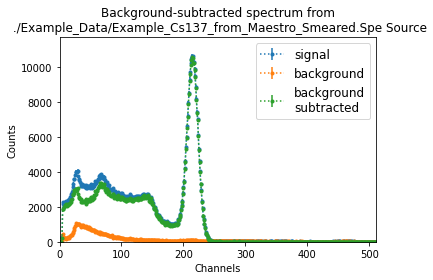

In [4]:
# Plot the background-subtracted spectrum in channel space
figuretitle   = 'Background-subtracted spectrum from\n '+ signalFile + ' Source' # set title for the graph
xlabeltext    = "Channels"                                                       # set x-axis label
ylabeltext    = "Counts"                                                         # set y-axis label
annotatetext1 = "Photopeak"                                                      # set text for annotation 1
yaxistype     = "linear"                                                         # choose 'log' or 'linear' for yscale

# select plotting symbols
signalSymbol     = '.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
backgroundSymbol = '.'       # choose colour and symbol for background data points 
subtractedSymbol = '.'       # choose colour and symbol for subtracted data points 

# find minimum and maximum x- and y-values in the data to be plotted
# set minimum and maximum scales for x- and y-axes

xplotmin = np.min(channel)
xplotmax = np.max(channel)
yplotmin = np.min(0)
yplotmax = np.max(signalYield)*1.1

# Set location for annotation

annotatexposition1 = xplotmin+0.1*(xplotmax-xplotmin) # use fraction between 0 and 1 to ensure position is within plot area
annotateyposition1 = yplotmin+0.8*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# plot and save the graph

plt.yscale(yaxistype)                                                   # plot 'log' or 'linear' for yscale
#plt.rcParams['font.size'] = 20                                          # set font size for labels
#plt.rcParams["figure.figsize"] = (30,30)                                # set figure size (x,y) in inches
plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                      # plot the graph axes
plt.xlabel(xlabeltext)                                                  # add label for x-axis
plt.ylabel(ylabeltext)                                                  # add label for y-axis
plt.title(figuretitle)                                                  # add figure title
plt.errorbar(channel,signalYield,yerr=signalError,marker=signalSymbol,linestyle=':',label="signal")                              # plot foreground data
plt.errorbar(channel,backgroundYield,yerr=backgroundError,marker=backgroundSymbol,linestyle=':',label="background")                              # plot background data
plt.errorbar(channel,subtractedYield,yerr=subtractedError,marker=subtractedSymbol,linestyle=':',label="background\nsubtracted") # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                     # add legend to plot, locate upper right
#plt.annotate(annotatetext1,xy=(annotatexposition1,annotateyposition1))  # Sample annotation of graph
plt.tight_layout()
plt.savefig(outputfile1,bbox_inches = 'tight')                          # write out spectra to outputfile
plt.show()

In [5]:
# inital guess at parameters of fit

# range of fit (channels)

xfitlower = 190                     # lower x-limit of fit (in channels)
xfitupper = 250                     # upper x-limit of fit (in channels)

# parameters of peak

amplitude = 110000                   # initial guess at amplitude
centroid  = 220                     # initial guess at centroid (in channels)
FWHM      = 20.0                    # initial guess at full width half maximum (FWHM) (in channels) 

# background terms (recommend starting from zero)

constant  = 0.0                     # initial value of constant background term
linear    = 0.0                     # initial value of linear background term
quadratic = 0.0                     # initial value of quadratic background term

# set up arrays for the range of data to be fitted
xfitdata    = channel[xfitlower:xfitupper]
yfitdata    = subtractedYield[xfitlower:xfitupper]
yerrfitdata = subtractedError[xfitlower:xfitupper]

Define the Gaussian plus background function to be fitted

      x is the data ordinate
      the remaining arguments are the function parameters:
          a is the amplitude
          x0 is the centroid
          sigma is the standard deviation
          const is constant background
          lin is linear background term
          quad is quadratic background term  

In [6]:
# Change the background form and number of Gaussians to be fit if there is more than one
        
def gaus(x,a,x0,sigma):
    peak = a*exp(-(x-x0)**2/(2*sigma**2))
    return peak
        
def polybackground(x,const,lin,quad):
    background = const+lin*x+quad*x*x
    return background
        
def signalFit(x,a,x0,sigma,const,lin,quad):
    peak = gaus(x,a,x0,sigma)
    background = polybackground(x,const,lin,quad)
    return peak+background

Fit the data and plot fit

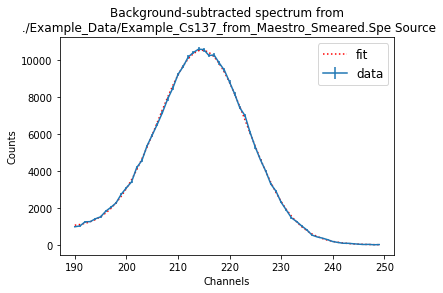

In [7]:
sigma=FWHM/2.355                    # calculate sigma from FWHM
params  = [amplitude,centroid,sigma,constant,linear,quadratic] # array for initial fit parameters    

# fit the function to the data
     # gaus is the function to be fitted
     # x is the data crdinate
     # y is the data co-ordinate
     # params is a list of the inital guesses at the parameter values
     # sigma is error in the co-ordinate data
        
popt,pcov = curve_fit(signalFit,xfitdata,yfitdata,p0=params,sigma=yerrfitdata)

# plot the fit

xplotmin = min(xfitdata)
xplotmax = max(xfitdata)
yplotmax = popt[0]*2.0

plt.axis()#[xplotmin, xplotmax, yplotmin, yplotmax])                     # plot the graph axes
#plt.ylim(top=90)                                                        #set upper y axis value 
#plt.ylim(bottom=0)                                                      # set lower y axis value
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdata,yfitdata,yerr=yerrfitdata,label='data')            # plot original data
plt.plot(xfitdata,signalFit(xfitdata,*popt),'r:',label='fit')            # plot fitted function
#plt.plot(xfitdata,gaus(xfitdata,*params),'c:',label='initial guess')    # plot initial function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
plt.show()                                                               # plot the graph

In [8]:
# calculate output values
# amplitude, integral, centroid, standard deviation, and full width at half maximum (FWHM).

amplitude = popt[0]
centroid  = popt[1]
sigma     = popt[2]
constant  = popt[3]
linear    = popt[4]
quadratic = popt[5]
integral  = 2.5066*amplitude*sigma
FWHM      = 2.355*sigma

perr = np.sqrt(np.diag(pcov))

amplitudeerror = perr[0]
centroiderror  = perr[1]
sigmaerror     = perr[2]
FWHMerror      = 2.355*sigmaerror
integralerror  = math.sqrt((amplitudeerror**2)/(amplitude**2)+(sigmaerror**2)/(sigma**2))*integral

params2 = [constant,linear,quadratic]      # array for plotting fitted background parameters

# print out peak parameters in channel space

print('Peak amplitude          is ', np.around(amplitude,decimals=2),u"\u00B1",np.around(amplitudeerror,decimals=2),'    counts')
print('Peak integral (net)     is ', np.around(integral,decimals=2),u"\u00B1",np.around(integralerror,decimals=2),' counts')
print('Peak centroid           is ', np.around(centroid,decimals=2),u"\u00B1",np.around(centroiderror,decimals=2),'      channels')
print('Peak standard deviation is ', np.around(sigma,decimals=2),u"\u00B1",np.around(sigmaerror,decimals=2),'        channels')
print('Peak FWHM               is ', np.around(FWHM,decimals=2),u"\u00B1",np.around(FWHMerror,decimals=2),'      channels')

Peak amplitude          is  10209.55 ± 40.61     counts
Peak integral (net)     is  223284.43 ± 1354.97  counts
Peak centroid           is  214.79 ± 0.03       channels
Peak standard deviation is  8.73 ± 0.04         channels
Peak FWHM               is  20.55 ± 0.09       channels


In [9]:
# input energy calibration and actual peak energy, if known.

calibrationgradient = 3.0   # units of keV/channel 
calibrationoffset   = 4      # units of keV
peakenergy          = 1333    # known peak energy in keV

# convert fitted parameters from channels to energy and calculate resolution

centroide = centroid*calibrationgradient + calibrationoffset   # centroid in keV
centroideerror= centroiderror*calibrationgradient
FWHMe = FWHM*calibrationgradient                               # FWHM in keV 
FWHMeerror= FWHMerror*calibrationgradient
resolution1 = 100*FWHMe/centroide   # resolution calucated from gaussian fitted width and centroid
resolution1error = math.sqrt((centroideerror**2)/(centroide**2)+(FWHMeerror**2)/(FWHMe**2))*resolution1
resolution2 = 100*FWHMe/peakenergy  # resolution caluclated from gaussian fitted width and known peak energy
resolution2error = (FWHMeerror/FWHMe)*resolution2

# print out peak parameters in energy space

print('Peak centroid   is ', np.around(centroide,decimals=2),u"\u00B1",np.around(centroideerror,decimals=2),' keV')
print('Peak FWHM       is ', np.around(FWHMe,decimals=2),u"\u00B1",np.around(FWHMeerror,decimals=2),'  keV')
print('Peak resolution is ', np.around(resolution1,decimals=2),u"\u00B1",np.around(resolution1error,decimals=2),'% (from measured width and centroid)' )
print('Peak resolution is ', np.around(resolution2,decimals=2),u"\u00B1",np.around(resolution2error,decimals=2),'% (from measured width and known peak energy)')

Peak centroid   is  648.37 ± 0.1  keV
Peak FWHM       is  61.64 ± 0.28   keV
Peak resolution is  9.51 ± 0.04 % (from measured width and centroid)
Peak resolution is  4.62 ± 0.02 % (from measured width and known peak energy)


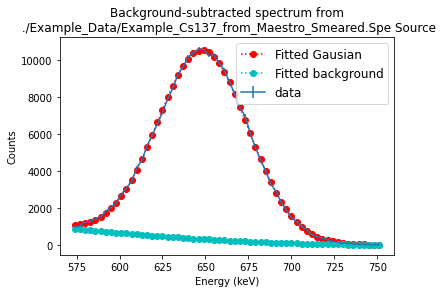

In [10]:
# replot fitted Gaussian in energy space

# convert the x-data points to energy

xfitdatae = calibrationgradient*xfitdata+calibrationoffset

# Caculate parameters for the graph    
    
xplotmin = min(xfitdatae)
xplotmax = max(xfitdatae)  
yplotmax = 2.0*amplitude  
halfwidthxlow = centroide - 0.5*FWHMe
halfwidthxhigh = centroide + 0.5*FWHMe
halfheight = amplitude/2+constant+centroid*linear+centroid*centroid*quadratic
fullheight = amplitude+constant+centroid*linear+centroid*centroid*quadratic
FWHMeround = round(FWHMe,2)
FWHMtext   = 'FWHM '+str(FWHMeround)+ ' keV'
centroideround = round(centroide,2)
centroidtext= 'Centroid ' + str(centroideround)+ ' keV'
centroidtextheight=halfheight*3
xlabeltext = "Energy (keV)"
ylabeltext = "Counts"

# Plot and save a graph of the fitted Gaussian 

#plt.axis([xplotmin,xplotmax,yplotmin,yplotmax])                          # set plot area
plt.axis()#[xplotmin, xplotmax, yplotmin, yplotmax])                     # plot the graph axes
#plt.ylim(top=amplitude*2)                                                        #set upper y axis value 
#plt.ylim(bottom=0)                                                      # set lower y axis value
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdatae,yfitdata,yerr=yerrfitdata,label='data')           # plot original data
plt.plot(xfitdatae,signalFit(xfitdata,*popt),'ro:',label='Fitted Gausian')    # plot fitted function
plt.plot(xfitdatae,polybackground(xfitdata,*params2),'co:',label='Fitted background') # plot background function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
#plt.plot([centroide,centroide],[yplotmin,fullheight],'-c')               # draw centroid position           
#plt.plot([halfwidthxlow,halfwidthxhigh],[halfheight,halfheight],'-c')    # draw FWHM
#plt.annotate(FWHMtext,xy=(halfwidthxlow+2+(halfwidthxhigh-halfwidthxlow)/2,halfheight+2))                    # annotate graph with FWHM
#plt.annotate(centroidtext,xy=(centroide,centroidtextheight))        # annotate graph with fitted centroid
plt.savefig(outputfile2,bbox_inches = 'tight')                           # write out fitted Gaussian to outputfile
plt.show()                                                               # plot the graph